<a href="https://colab.research.google.com/github/mantis2404/TSNE-From-Scratch/blob/main/T-SNE/t_sne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

In [ ]:
# testing dataset
digits=load_digits()
X=digits.data
target=digits.target
X=pd.DataFrame(X,columns=digits.feature_names)
target=target[X.index]
X=np.array(X)
X=X/16

### CALCULATING THE DISTANCE MATRIX

$$D_{ij} = \|x_i - x_j\|^2 $$
$$OR$$
$$D_{ij}=\|y_i - y_j\|^2$$

In [ ]:
def dist_matrix(X):
  D=np.sum(X**2,axis=1)
  D=D[:,None]+D[None,:]-2*np.dot(X,X.T)
  return D

### CALCULATING THE ASYMMETRIC CONDITIONAL PROBABILITY MATRIX FOR HIGH-DIMENSION

$$p_{j|i} = \frac{\exp(-\beta_i D_{ij})}{\sum_{k \ne i} \exp(-\beta_i D_{ik})}$$

In [ ]:
D=dist_matrix(X)
def probability_matrix(sigma,i):
  P_asym = np.zeros((X.shape[0],X.shape[0]))

  num=np.exp(-D[i,:]/(2*sigma**2))
  # self comparision is not needed
  # also while calculating the denominator i!=k case is also handled through it
  num[i]=0
  # probability matrix in high dimension is row wise normalized
  den=np.sum(num)
  den=np.maximum(den,1e-12)
  P_asym[i]=num/den

  return P_asym

### CALCULATING THE SYMMETRIC CONDITIONAL PROBABILITY MATRIX

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$$

In [ ]:
def symmetrize_matrix(m):
  n=m.shape[0]
  return (m+m.T)/(2*n)

### CALCULATING THE OPTIMAL VARIANCE FOR EACH POINT

$$Perp (P_i) = 2^{H(P_i)}$$

$$
H(P_i)=-\sum_j P_{j|i}log_2{ p_{j|i}}
$$

$$σ_i=\frac{σ_{min}+σ_{max}}{2}$$

In [ ]:
def sigma(perplexity,dist_m):
  h=math.log(perplexity,2) # shannon entropy
  max_iterations=30
  tolerance=1e-5
  sigma=np.zeros(X.shape[0])
  beta=np.ones(X.shape[0]) #sigma= 1 / sqrt(2 * beta)

  for j in range(X.shape[0]):
    beta_max=10
    beta_min=0.01
    #finding optimal sigma for one high dimension embedding
    for i in range(max_iterations):
      sigma[j]=1/math.sqrt(2*beta[j])
      p=probability_matrix(sigma[j],j) #calculate probability matrix from an assumed sigma by calling function
      p=np.array(p)
      p=p[j,:]
      p= np.maximum(p, 1e-10)
      h_cal=-np.sum(p*np.log2(p)) #added error in case of 0 probabilities
      if(abs(h_cal-h)<tolerance or (beta_max-beta_min)<1e-15):
        break

      if(h_cal>h):
          # Entropy too high->reduce sigma->increase beta
          beta_min=beta[j]
      else:
          # Entropy too low->increase sigma->decrease beta
          beta_max=beta[j]

      beta[j]=(beta_max+beta_min)/2
  return sigma

### INITIALIZING THE LOW DIMENSION EMBEDDIGNS

$$\{y_1,y_2,y_3.....y_n\}$$

In [ ]:
# initializing low dimensional embeddings on dimension: 'n_components' with mean 0 and some noise to avoid same gradients
def init_embed(n_components):
  return np.random.normal(loc=0.0, scale=1e-5, size=(X.shape[0],n_components))

### CALCULATING DISTANCE MATRIX IN LOW DIMENSION

$$D_{ij}=\|y_i - y_j\|^2$$

In [ ]:
n_components=2
y=init_embed(n_components)
D_low = dist_matrix(y)

### CALCULATING THE LOW DIMENSIONAL SYMMETRIC PROBABILITY MATRIX

$$q_{ij} = \frac{(1 + D_{ij})^{-1}}{\sum_{k \ne l} (1 + D_{kl})^{-1}}$$

In [ ]:
def low_dim_prob_matrix():
  den=0
  Q=(1+D_low)**(-1)
  np.fill_diagonal(Q,0)

  # probability matrix in low dimension is globally normalized, hence symmetric by default
  den=np.maximum(np.sum(Q),1e-20)
  Q=Q/den
  return Q

### GRADIENT DESCENT OPTIMIZATION

$$
\frac{\partial \text{KL}}{\partial y_i} = 4 \sum_{j \ne i} (p_{ij} - q_{ij}) \cdot \frac{y_i - y_j}{1 + \|y_i - y_j\|^2}
$$

In [ ]:
def gradient_descent(y,p,q):
  y_dist=dist_matrix(y)
  gradient=np.zeros_like(y)
  q=np.array(q)
  for i in range(y.shape[0]):
    weights=4*(p[i, :]-q[i, :])/(1+y_dist[i, :])
    gradient[i,:]=np.sum((weights[:, None])*(y[i, :]-y),axis=0)

  return gradient

### ADDING MOMENTUM

$$
\begin{aligned}
v_i^{(t+1)} &= \mu \cdot v_i^{(t)} - \eta \cdot \frac{\partial \text{KL}}{\partial y_i^{(t)}} \\\\
y_i^{(t+1)} &= y_i^{(t)} + v_i^{(t+1)}
\end{aligned}
$$

In [ ]:
v=np.zeros_like(y)
def update_with_momentum(learning_rate,momentum,y,P,Q,gains):
  global v
  grad=gradient_descent(y,P,Q)
  signs=grad*v<0
  gains[signs]+=0.15 #sign changed ->gain increases (reducing effective learning rate)
  gains[~signs]*=0.85
  gains=np.maximum(0.01,gains)

  v=momentum*v-learning_rate*gains*grad
  y=y+v
  '''
  for i in range(y.shape[0]):
    v[i,:]=momentum*v[i,:]-learning_rate*gains[i,:]*grad[i,:]
    y[i,:]=y[i,:]+v[i,:]
  '''
  return y,gains

### DEFINING THE T-SNE FUNCTION

In [ ]:
def tsne(X,perplexity,learning_rate,early_exaggeration,max_iter):
  global Q,y,D_low

  dist_m=dist_matrix(X)
  n=X.shape[0]
  gains=np.zeros_like(y)
  P=np.zeros((n,n))
  optimal_var=sigma(perplexity,dist_m)
  print("optimal sigma:",optimal_var)
  for i in range(X.shape[0]):
    temp_p=probability_matrix(optimal_var[i],i)
    temp_p=np.array(temp_p)
    P[i,:]=temp_p[i,:]
  P=symmetrize_matrix(P)
  P_exaggerated=P*early_exaggeration
  for i in range(max_iter):
    if(i<max_iter//4):
      cur_P=P_exaggerated
      momentum=0.5
    else:
      cur_P=P
      momentum=0.8
    Q=low_dim_prob_matrix()
    y,gains=update_with_momentum(learning_rate,momentum,y,cur_P,Q,gains)
    D_low=dist_matrix(y)
  return y

In [ ]:
%%time
Y=tsne(X,5,100,12,1000)

optimal sigma: [0.23868595 0.36617154 0.49339389 ... 0.30210596 0.3738896  0.42825924]
CPU times: user 11min 32s, sys: 8min 43s, total: 20min 15s
Wall time: 17min 50s


<Axes: >

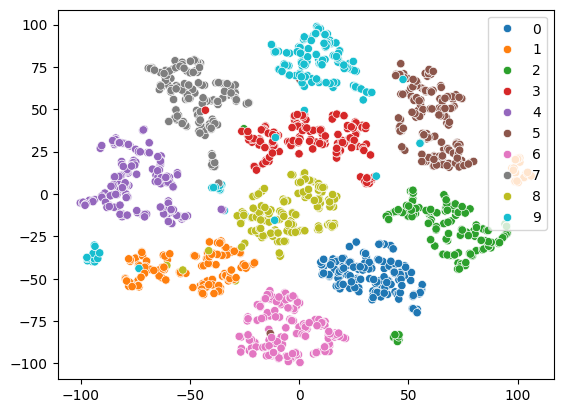

In [ ]:
sns.scatterplot(x=y[:,0],y=y[:,1],hue=target,palette='tab10')

In [ ]:
%%time
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne = tsne.fit_transform(X)

CPU times: user 10.3 s, sys: 32 ms, total: 10.3 s
Wall time: 10.3 s


<Axes: >

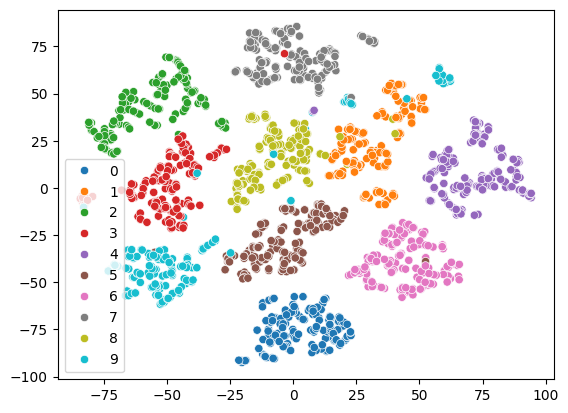

In [ ]:
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],hue=target,palette='tab10')